<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC 
## Timeseries of FLEXPART and measured eBC


In this example, FLEXPART modelled black carbon (BC) are compared with measured equivalent black carbon (eBC) at Birkenes. eBC might exist as a combined product in the ACTRIS data portal, if not eBC will be derieved from aerosol light absorption coefficients. The calculation of equivalent black carbon is shown in notebook "Equivalent black carbon (eBC).ipynb", and is the same for both *combined products* (https://vocabulary.actris.nilu.no/skosmos/actris_vocab/en/page/combinedproduct) (in this case datasets with pre-calculated equivalent black carbon) and *observation products* (https://vocabulary.actris.nilu.no/skosmos/actris_vocab/en/page/observation) (datasets with hourly values of the standard ACTRIS variable aerosol particle light absorption coefficient). In both cases eBC is calculated from the absorption coefficient at 637 nm, devided by the MAC conversion factor. If the data does not contain the reference wavelength, it is interpolated with the Ångstrøm exponent.  

This example is organized as follows:

(1) &nbsp;&nbsp; Define all python libraries needed

(2) &nbsp;&nbsp;  Specify input files, define variables, and set the month to be studied/plotted

(3) &nbsp;&nbsp;  Read FLEXPART data and make a simple test plot

(4) &nbsp;&nbsp;  Read ACTRIS data and check the content, e.g., absorption coefficients 

(5) &nbsp; Check if eBC exists as a level 3 product. If not, calculate Ångstøm coefficients ($\alpha$) and absorption coefficients at 637nm (if needed)
 
&emsp;&emsp;&emsp;&emsp;  $\alpha=ln(\frac{abs_{470nm}}{abs_{660nm}}) /ln(\frac{660}{470})  $ 

&emsp;&emsp;&emsp;&emsp;  $abs_{637nm}={abs_{660nm}}(\frac{637}{660})^{-\alpha} $ 

&emsp;&emsp;&emsp;&emsp;  Plot the Ångstrøm coefficients as a test

&emsp;&emsp;  And calculate Equivalent Black carbon (eBC)

&emsp;&emsp;&emsp;&emsp;  $eBC_{637nm}=\frac{abs_{637nm}}{MAC_{637nm}}$

(6) &nbsp;&nbsp;  Plot eBC from FLEXPART and measurements for one month

### 1. Import libraries 

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import plotly.express as px
import re
import requests
import matplotlib.pyplot as plt
from io import StringIO

### 2. Define file names and variables

In [15]:
# FLEXPART file (from ACTRIS data portal, Services: ATMO-ACCESS Flexpart)

#Flex_file = 'https://atmo-access.nilu.no/WEBPLOTS/NO0002R/2022/OUT_202201_0/ECMWF/sourcespectrum_TOTAL_BC_a_OUT_202201_0.dat' # file that contains the BC sources for the month of January 2022
Flex_file = 'https://atmo-access.nilu.no/WEBPLOTS/NO0002R/2023/OUT_202302_0/ECMWF/sourcespectrum_TOTAL_BC_a_OUT_202302_0.dat' # file that contains the BC sources for the month of February 2023

# Observation file (from ACTRIS data portal) 
#Obs_file = 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/EJ/DP/Q2/EJDP-Q2TQ.nc' # file that contains the data for the month of January 2022, this is a *observation* file, i.e. contains aerosol absorption coefficient measurements
Obs_file = 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/KC/Q9/7U/KCQ9-7U9Q.nc' # file that contains data for the month of February 2023, this is a *combined* file, i.e. contains pre-calculated eBC concentrations

# Constants for calculating eBC
lambda_ref=637.
MAC=10

# Month to be analyzed, change this to the month you want to analyze
#month='2022-01'
month='2023-02' 


### 3. Read FLEXPART data and make a test plot

    UNIT           START             END    LON      LAT      DOM     ENE  \
0  ng/m3  20230201000000  20230201030000  8.252  58.3885  17.2900  0.2538   
1  ng/m3  20230201030000  20230201060000  8.252  58.3885  23.4763  0.2789   
2  ng/m3  20230201060000  20230201090000  8.252  58.3885  20.5765  0.3193   
3  ng/m3  20230201090000  20230201120000  8.252  58.3885  13.8812  0.1859   
4  ng/m3  20230201120000  20230201150000  8.252  58.3885  13.6053  0.1451   

      FLR     IND     SHP     WST     TRA      BB  
0  1.9440  1.7208  0.3720  0.4953  6.6918  1.6699  
1  2.1129  2.2984  0.3422  0.6202  9.4350  1.3629  
2  3.1455  2.0917  0.3651  0.5499  8.1086  1.0050  
3  3.5289  1.4182  0.3136  0.3279  5.6985  0.4056  
4  4.3181  1.3316  0.3571  0.2441  5.4814  0.1620  


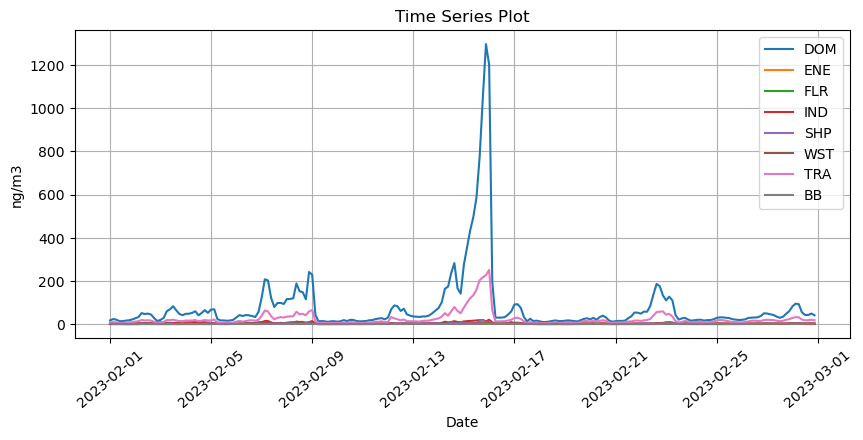

In [16]:
# FLEXPART-file (Flex_file) is defined above. Send a GET request to the URL
response = requests.get(Flex_file)

# Check if the request was successful
if response.status_code == 200:
    # Read the content into a pandas DataFrame
    data = StringIO(response.text)
    df = pd.read_csv(data, delim_whitespace=True)
    
    # Display the first few rows to understand its structure
    print(df.head())
    
    # Select date/time column
    time_column = df.columns[1]  
    
    # Convert the time column to datetime
    df[time_column] = pd.to_datetime(df[time_column], format='%Y%m%d%H%M%S')
    
    # Select various eBC sources
    ebc_flexpart = 'eBC_Flexpart'
    value_column1 = df.columns[5]  # DOM
    value_column2 = df.columns[6]  # ENE
    value_column3 = df.columns[7]  # FLR
    value_column4 = df.columns[8]  # IND
    value_column5 = df.columns[9]  # SHP
    value_column6 = df.columns[10]  # WST
    value_column7 = df.columns[11]  # TRA
    value_column8 = df.columns[12]  # BB
    # Total eBC from Flexpart
    df[ebc_flexpart] = df[[value_column1, value_column2, value_column3, value_column4, value_column5, 
                           value_column6, value_column7, value_column8]].sum(axis=1)

    # Plot the time series to check
    plt.figure(figsize=(10, 4))
    plt.plot(df[time_column], df[value_column1])
    plt.plot(df[time_column], df[value_column2])
    plt.plot(df[time_column], df[value_column3])
    plt.plot(df[time_column], df[value_column4])
    plt.plot(df[time_column], df[value_column5])
    plt.plot(df[time_column], df[value_column6])
    plt.plot(df[time_column], df[value_column7])
    plt.plot(df[time_column], df[value_column8])
    #plt.plot(df[time_column], df[ebc_flexpart])
    
    plt.xlabel('Date')
    plt.ylabel('ng/m3')
    plt.title('Time Series Plot')
    plt.xticks(rotation=40)
    plt.legend(['DOM', 'ENE', 'FLR', 'IND', 'SHP', 'WST', 'TRA', 'BB'])
    plt.grid(True)
    plt.show()

else:
    print(f"Failed to download the file. Status code: {response.status_code}")


### 4. Read ACTRIS data

In [17]:
# Open the dataset 
inst_data = xr.open_dataset(Obs_file) 

all_wavelengths = inst_data.Wavelength.values
time=inst_data.time.values 

print("Wavelengths:",all_wavelengths)

# Find the wavelength closest to the reference wavelength and the shortest wavelength
lambda_long = min(all_wavelengths, key=lambda x:abs(x-lambda_ref))
lambda_short = min(all_wavelengths)

print("Wavelength closest to ref:",lambda_long)
print("Shortest wavelength:",lambda_short)


Wavelengths: [637.]
Wavelength closest to ref: 637.0
Shortest wavelength: 637.0


### 5. Calculate Ångstrøm exponent from observations, calculate eBC

In [18]:
# Check if eBC exists as a level 3 product. If not, calculate eBC from absorption coefficients

if 'equivalent_black_carbon_amean' in inst_data.variables:
    # Read eBC level 3 product and convert to dataframe
    df_eBC_ref = inst_data.equivalent_black_carbon_amean.rename('eBC_measured').to_dataframe().reset_index().set_index('time')
    print("eBC exists as a level 3 product")   
else:
    # Select absorption coefficients at two wavelengths defined above
    abs_short = inst_data.sel(Wavelength=lambda_short).aerosol_absorption_coefficient_amean
    abs_long = inst_data.sel(Wavelength=lambda_long).aerosol_absorption_coefficient_amean

    # Create empty arrays with length of dataset
    A = len(abs_long)
    abs_coeff = np.zeros(A)     #Abs. coeff. at reference wavelength
    eBC_ref = np.zeros(A)       #eBC at reference wavelength
    alpha = np.zeros(A)         #Ångström exponent

    # Calculate Ångström exponent (alpha)
    if lambda_long == lambda_ref:
        alpha = 0.0
    else:
        alpha = (np.log(abs_short/abs_long)) / (np.log(lambda_long/lambda_short))
        alpha[alpha < 0.1] = 0.7
        alpha[alpha > 3.0] = 3.0
        
        #Plot the Ångström exponent
        plt.figure(figsize=(10, 4))
        plt.plot(time,alpha)


    # Calculate absorption coefficient and eBC at reference wavelength
    abs_coeff = ((lambda_ref/lambda_long)**(-alpha))*abs_long
    eBC_ref = (abs_coeff /MAC).rename('eBC_measured')
    
    # Convert to Dataframe
    df_eBC_ref = eBC_ref.to_dataframe()



eBC exists as a level 3 product


### 6. Plot eBC from observations and Flexpart

In [19]:
# Extract the time period specified above
df_hour_ref_month = df_eBC_ref.eBC_measured[month]
x=df_hour_ref_month.index[:]

# Plot option 1 (not visible in pdf):
#####################################
# Create station name: a)selct the first part of the name, b)remove non-alphanumeric characters 
station_name_full = inst_data.ebas_station_name
station_string = inst_data.ebas_station_name.split(" ",1)[0]
station_name = re.sub('\W+','', station_string)

# Create plot with specified size
fig=px.line(df_hour_ref_month)
fig.add_scatter(x=df[time_column], y=df[ebc_flexpart]/1000, name="eBC_Flexpart", xaxis='x', yaxis='y')

fig.update_layout(
    title="Equivalent Black Carbon (eBC) at Birkenes",
    xaxis_title="Time",
    yaxis_title="µg/m3",
    font=dict(
        family="Courier New, monospace",
        size=16,
        color="RebeccaPurple"
    ),
    width=1500,  # Specify the width of the plot
    height=500   # Specify the height of the plot
)
fig.show() 


To see a more detailed calculation of equvalent black carbon from measurement aerosol absorption coefficient data, please have a look at "Equivalent black carbon (eBC).ipynb". 

To have a look at footprint emission sensitivity analysis from the FLEXPART model, please have a look at "FLEXPART footprint emission for black carbon.ipynb". 